In [344]:
import sys # os stands for "operating system" and includes read/write routines etc. 
import mkl
from src import utils # this is our own library of functions
mkl.set_num_threads(10)
%matplotlib inline
%load_ext autoreload
%autoreload 2
# %matplotlib notebook # if you need to zoom into a figure, this is the "interactive" mode of IPython
#sys.path.insert(0, '/home/mano/Documents/Profesional Projects/Suite2p/suite2p/') #linux import
sys.path.insert(0,r'C:\Users\WinDesktopMP\Documents\suite2p')
from matplotlib import pyplot as plt # all of our |plotting is done with plt
import numpy as np
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [644]:
exp_db = []
exp_db = utils.add_exp(exp_db, 'DR10', '2022_07_11', '1')
exp_db = utils.add_exp(exp_db, 'TX80', '2022_06_17', '1')

In [398]:
iexp       = 0
timeline   = utils.load_exp_info(exp_db[iexp])
spks, xpos, ypos, iplane, stat, ops = utils.load_neurons(exp_db[iexp], dual_plane=True, baseline=True)

(20,)
plane 0,  neurons: 3232
plane 1,  neurons: 4971
plane 2,  neurons: 4518
plane 3,  neurons: 3013
plane 4,  neurons: 1216
plane 5,  neurons: 1729
plane 6,  neurons: 4535
plane 7,  neurons: 4967
plane 8,  neurons: 4389
plane 9,  neurons: 3163
plane 10,  neurons: 1458
plane 11,  neurons: 2687
plane 12,  neurons: 2282
plane 13,  neurons: 2123
plane 14,  neurons: 1418
plane 15,  neurons: 1805
plane 16,  neurons: 1969
plane 17,  neurons: 2099
plane 18,  neurons: 2837
plane 19,  neurons: 1685
total neurons 56096


In [314]:
FRAMES_PASSIVE = ops["frames_per_folder"][0]
spks = spks[:,:FRAMES_PASSIVE]

In [315]:
neurons_atframes, subset_stim = utils.get_neurons_atframes(timeline,spks)
avg_response, csig = utils.get_tuned_neurons(neurons_atframes, subset_stim)
csig.mean()

0.03148167

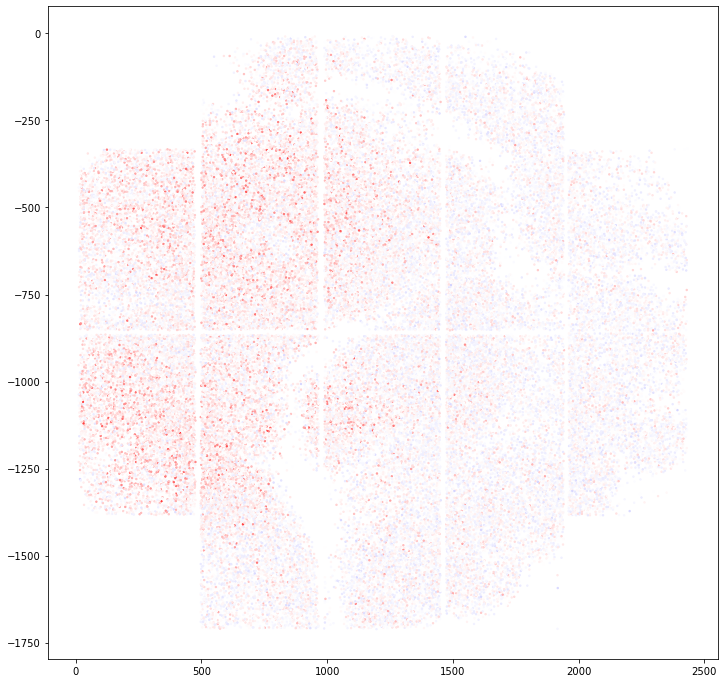

In [316]:
plt.figure(figsize=(12,12))
plt.scatter(xpos, -ypos, c = csig, cmap = 'bwr', vmax = 1, vmin=-1, s = 2)

In [317]:
categories_dict = {
    "0":"leaves",
    "1":"circles",
    "2":"dryland",
    "3":"rocks",
    "4":"tiles",
    "5":"squares",
    "6":"round leaves",
    "7":"paved"}

In [318]:
cats, stim_idx = utils.get_stim_class_and_samples_ix(subset_stim, n_categories=8, samples_per_cat=4)

8 categories, 32 exemplars, 25 repeats


AFC without averaging over repeats

In [341]:
from src.utils import DprimeDecoder
train_category = np.arange(0,len(cats),2)  #even category is the start of a new pair
train_texture = np.arange(4)
accurracy = []
for category in train_category:
    for texture in train_texture:
        neurons_at_cats = utils.select_neurons_by_stimsubset(neurons_atframes, stim_idx, cats, category_tostart=category, exemplars_to_take=8)
        X_train = neurons_at_cats[:, :, ::2] #Even repeats for training
        X_test = neurons_at_cats[:, :, 1::2] #Odd repeats for testing
        decoder = DprimeDecoder(samples_per_category=4, train_exemplar=texture, threshold=0.5, decisionrule="midpoint")
        decoder.fit(X_train, iplane, zstack=2)
        decoder.test(X_test, iplane, zstack=2)
        acc = decoder.score(avg_test_reps = False, AFC = True)
        print(f" category: {categories_dict[str(category)]}, exemplar trained: {texture}, accuracy: {acc}")
        accurracy.append(acc)
accurracy = np.array(accurracy).reshape(4,4)
print('############### OVERALL MEAN #####################')
category_pairs = ["leaves/circles","dryland/rocks","tiles/squares","round leaves/paved"]
for cat in range(4):
    acc = accurracy[cat].mean(-1)
    print(f" category: {category_pairs[cat]}, average accuracy: {acc}")

 category: leaves, exemplar trained: 0, accuracy: 75.0
 category: leaves, exemplar trained: 1, accuracy: 87.5
 category: leaves, exemplar trained: 2, accuracy: 70.83333333333334
 category: leaves, exemplar trained: 3, accuracy: 83.33333333333334
 category: dryland, exemplar trained: 0, accuracy: 70.83333333333334
 category: dryland, exemplar trained: 1, accuracy: 37.5
 category: dryland, exemplar trained: 2, accuracy: 72.91666666666666
 category: dryland, exemplar trained: 3, accuracy: 66.66666666666666
 category: tiles, exemplar trained: 0, accuracy: 66.66666666666666
 category: tiles, exemplar trained: 1, accuracy: 72.91666666666666
 category: tiles, exemplar trained: 2, accuracy: 54.166666666666664
 category: tiles, exemplar trained: 3, accuracy: 77.08333333333334
 category: round leaves, exemplar trained: 0, accuracy: 89.58333333333334
 category: round leaves, exemplar trained: 1, accuracy: 89.58333333333334
 category: round leaves, exemplar trained: 2, accuracy: 87.5
 category: ro

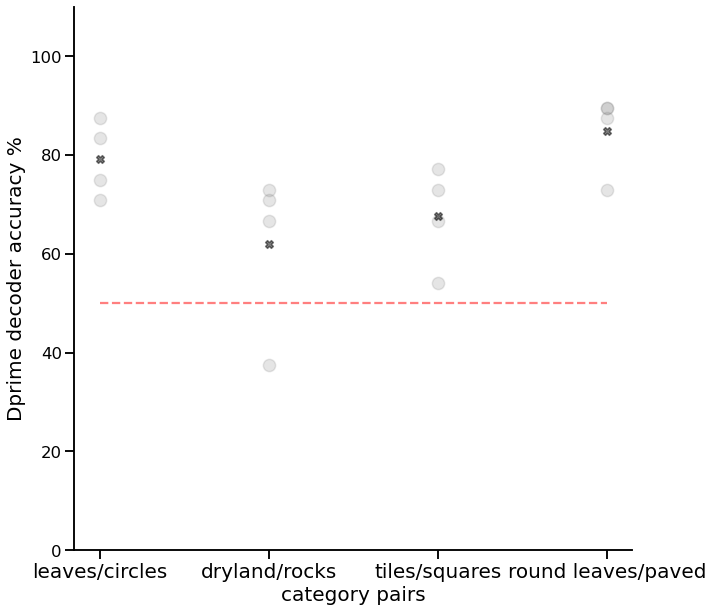

In [343]:
sns.set_context("talk")
plt.figure(figsize=(10,10))
for cat in range(4):
    y = accurracy[cat,:]
    x = np.ones(4) * cat
    plt.scatter(x,y, alpha = 0.2 , s = 150, color= "gray")
    plt.scatter(x[0],y.mean(),marker="X",c="k",s=60, alpha = 0.5)
plt.ylabel("Dprime decoder accuracy %", size = 20)
plt.hlines(y=50,xmin=0,xmax=3, linestyles="--", color = "red", alpha = 0.5)
plt.xticks([0,1,2,3],["leaves/circles", "dryland/rocks", "tiles/squares", "round leaves/paved"], size = 20)
plt.xlabel("category pairs", size = 20);
plt.ylim(0,110)
sns.despine()

AFC averaging over repeats

In [352]:
from src.utils import DprimeDecoder
train_category = np.arange(0,len(cats),2)  #even category is the start of a new pair
train_texture = np.arange(4)
accurracy = []
for category in train_category:
    for texture in train_texture:
        neurons_at_cats = utils.select_neurons_by_stimsubset(neurons_atframes, stim_idx, cats, category_tostart=category, exemplars_to_take=8)
        X_train = neurons_at_cats[:, :, ::2] #Even repeats for training
        X_test = neurons_at_cats[:, :, 1::2] #Odd repeats for testing
        decoder = DprimeDecoder(samples_per_category=4, train_exemplar=texture, threshold=0.5, decisionrule="midpoint")
        decoder.fit(X_train, iplane, zstack=2)
        decoder.test(X_test, iplane, zstack=2)
        acc = decoder.score(avg_test_reps = True, AFC = True)
        print(f" category: {categories_dict[str(category)]}, exemplar trained: {texture}, accuracy: {acc}")
        accurracy.append(acc)
accurracy = np.array(accurracy).reshape(4,4)
print('############### OVERALL MEAN #####################')
category_pairs = ["leaves/circles","dryland/rocks","tiles/squares","round leaves/paved"]
for cat in range(4):
    acc = accurracy[cat].mean(-1)
    print(f" category: {category_pairs[cat]}, average accuracy: {acc}")

 category: leaves, exemplar trained: 0, accuracy: 100.0
 category: leaves, exemplar trained: 1, accuracy: 100.0
 category: leaves, exemplar trained: 2, accuracy: 100.0
 category: leaves, exemplar trained: 3, accuracy: 100.0
 category: dryland, exemplar trained: 0, accuracy: 75.0
 category: dryland, exemplar trained: 1, accuracy: 25.0
 category: dryland, exemplar trained: 2, accuracy: 75.0
 category: dryland, exemplar trained: 3, accuracy: 100.0
 category: tiles, exemplar trained: 0, accuracy: 75.0
 category: tiles, exemplar trained: 1, accuracy: 100.0
 category: tiles, exemplar trained: 2, accuracy: 50.0
 category: tiles, exemplar trained: 3, accuracy: 100.0
 category: round leaves, exemplar trained: 0, accuracy: 100.0
 category: round leaves, exemplar trained: 1, accuracy: 100.0
 category: round leaves, exemplar trained: 2, accuracy: 100.0
 category: round leaves, exemplar trained: 3, accuracy: 100.0
############### OVERALL MEAN #####################
 category: leaves/circles, average

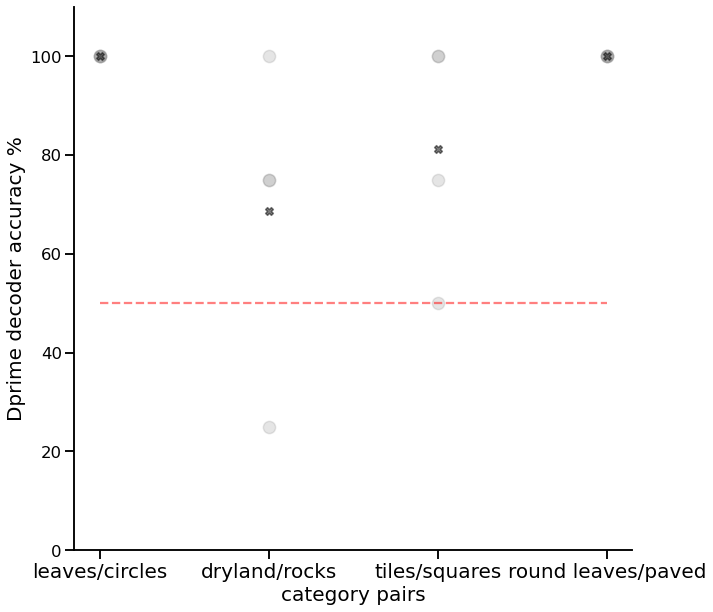

In [351]:
sns.set_context("talk")
plt.figure(figsize=(10,10))
for cat in range(4):
    y = accurracy[cat,:]
    x = np.ones(4) * cat
    plt.scatter(x,y, alpha = 0.2 , s = 150, color= "gray")
    plt.scatter(x[0],y.mean(),marker="X",c="k",s=60, alpha = 0.5)
plt.ylabel("Dprime decoder accuracy %", size = 20)
plt.hlines(y=50,xmin=0,xmax=3, linestyles="--", color = "red", alpha = 0.5)
plt.xticks([0,1,2,3],["leaves/circles", "dryland/rocks", "tiles/squares", "round leaves/paved"], size = 20)
plt.xlabel("category pairs", size = 20);
plt.ylim(0,110)
sns.despine()

# Layer 2/3 neurons: 
## Wo averaging over repeats 

In [354]:
train_category = np.arange(0,len(cats),2)  #even category is the start of a new pair
train_texture = np.arange(4)
accurracy = []
for category in train_category:
    for texture in train_texture:
        neurons_at_cats = utils.select_neurons_by_stimsubset(neurons_atframes, stim_idx, cats, category_tostart=category, exemplars_to_take=8)
        X_train = neurons_at_cats[:, :, ::2] #Even repeats for training
        X_test = neurons_at_cats[:, :, 1::2] #Odd repeats for testing
        decoder = DprimeDecoder(samples_per_category=4, train_exemplar=texture, threshold=0.5, decisionrule="midpoint")
        decoder.fit(X_train, iplane, zstack=1)
        decoder.test(X_test, iplane, zstack=1)
        acc = decoder.score(avg_test_reps = False, AFC = True)
        print(f" category: {categories_dict[str(category)]}, exemplar trained: {texture}, accuracy: {acc}")
        accurracy.append(acc)
accurracy = np.array(accurracy).reshape(4,4)
print('############### OVERALL MEAN #####################')
category_pairs = ["leaves/circles","dryland/rocks","tiles/squares","round leaves/paved"]
for cat in range(4):
    acc = accurracy[cat].mean(-1)
    print(f" category: {category_pairs[cat]}, average accuracy: {acc}")

 category: leaves, exemplar trained: 0, accuracy: 81.25
 category: leaves, exemplar trained: 1, accuracy: 83.33333333333334
 category: leaves, exemplar trained: 2, accuracy: 75.0
 category: leaves, exemplar trained: 3, accuracy: 70.83333333333334
 category: dryland, exemplar trained: 0, accuracy: 66.66666666666666
 category: dryland, exemplar trained: 1, accuracy: 47.91666666666667
 category: dryland, exemplar trained: 2, accuracy: 66.66666666666666
 category: dryland, exemplar trained: 3, accuracy: 72.91666666666666
 category: tiles, exemplar trained: 0, accuracy: 75.0
 category: tiles, exemplar trained: 1, accuracy: 75.0
 category: tiles, exemplar trained: 2, accuracy: 58.333333333333336
 category: tiles, exemplar trained: 3, accuracy: 83.33333333333334
 category: round leaves, exemplar trained: 0, accuracy: 85.41666666666666
 category: round leaves, exemplar trained: 1, accuracy: 83.33333333333334
 category: round leaves, exemplar trained: 2, accuracy: 87.5
 category: round leaves, 

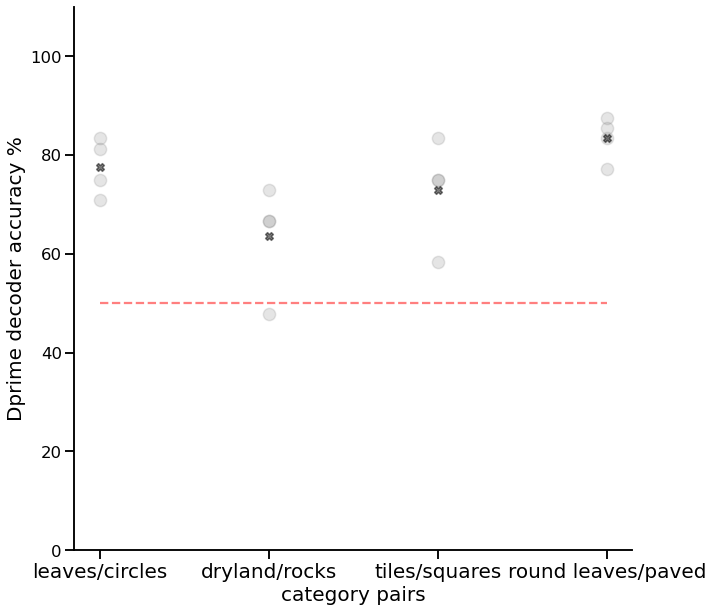

In [355]:
sns.set_context("talk")
plt.figure(figsize=(10,10))
for cat in range(4):
    y = accurracy[cat,:]
    x = np.ones(4) * cat
    plt.scatter(x,y, alpha = 0.2 , s = 150, color= "gray")
    plt.scatter(x[0],y.mean(),marker="X",c="k",s=60, alpha = 0.5)
plt.ylabel("Dprime decoder accuracy %", size = 20)
plt.hlines(y=50,xmin=0,xmax=3, linestyles="--", color = "red", alpha = 0.5)
plt.xticks([0,1,2,3],["leaves/circles", "dryland/rocks", "tiles/squares", "round leaves/paved"], size = 20)
plt.xlabel("category pairs", size = 20);
plt.ylim(0,110)
sns.despine()

# Averaging over repeats 

In [356]:
train_category = np.arange(0,len(cats),2)  #even category is the start of a new pair
train_texture = np.arange(4)
accurracy = []
for category in train_category:
    for texture in train_texture:
        neurons_at_cats = utils.select_neurons_by_stimsubset(neurons_atframes, stim_idx, cats, category_tostart=category, exemplars_to_take=8)
        X_train = neurons_at_cats[:, :, ::2] #Even repeats for training
        X_test = neurons_at_cats[:, :, 1::2] #Odd repeats for testing
        decoder = DprimeDecoder(samples_per_category=4, train_exemplar=texture, threshold=0.5, decisionrule="midpoint")
        decoder.fit(X_train, iplane, zstack=1)
        decoder.test(X_test, iplane, zstack=1)
        acc = decoder.score(avg_test_reps = True, AFC = True)
        print(f" category: {categories_dict[str(category)]}, exemplar trained: {texture}, accuracy: {acc}")
        accurracy.append(acc)
accurracy = np.array(accurracy).reshape(4,4)
print('############### OVERALL MEAN #####################')
category_pairs = ["leaves/circles","dryland/rocks","tiles/squares","round leaves/paved"]
for cat in range(4):
    acc = accurracy[cat].mean(-1)
    print(f" category: {category_pairs[cat]}, average accuracy: {acc}")

 category: leaves, exemplar trained: 0, accuracy: 100.0
 category: leaves, exemplar trained: 1, accuracy: 100.0
 category: leaves, exemplar trained: 2, accuracy: 75.0
 category: leaves, exemplar trained: 3, accuracy: 75.0
 category: dryland, exemplar trained: 0, accuracy: 75.0
 category: dryland, exemplar trained: 1, accuracy: 25.0
 category: dryland, exemplar trained: 2, accuracy: 50.0
 category: dryland, exemplar trained: 3, accuracy: 100.0
 category: tiles, exemplar trained: 0, accuracy: 75.0
 category: tiles, exemplar trained: 1, accuracy: 100.0
 category: tiles, exemplar trained: 2, accuracy: 50.0
 category: tiles, exemplar trained: 3, accuracy: 100.0
 category: round leaves, exemplar trained: 0, accuracy: 100.0
 category: round leaves, exemplar trained: 1, accuracy: 100.0
 category: round leaves, exemplar trained: 2, accuracy: 100.0
 category: round leaves, exemplar trained: 3, accuracy: 100.0
############### OVERALL MEAN #####################
 category: leaves/circles, average a

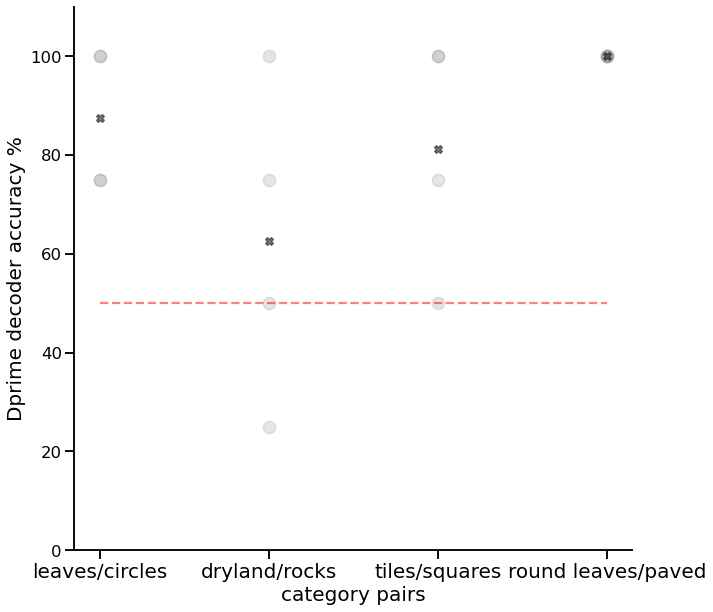

In [357]:
sns.set_context("talk")
plt.figure(figsize=(10,10))
for cat in range(4):
    y = accurracy[cat,:]
    x = np.ones(4) * cat
    plt.scatter(x,y, alpha = 0.2 , s = 150, color= "gray")
    plt.scatter(x[0],y.mean(),marker="X",c="k",s=60, alpha = 0.5)
plt.ylabel("Dprime decoder accuracy %", size = 20)
plt.hlines(y=50,xmin=0,xmax=3, linestyles="--", color = "red", alpha = 0.5)
plt.xticks([0,1,2,3],["leaves/circles", "dryland/rocks", "tiles/squares", "round leaves/paved"], size = 20)
plt.xlabel("category pairs", size = 20);
plt.ylim(0,110)
sns.despine()

# All pairwise comparisons:

In [529]:
from itertools import combinations
from sklearn.metrics import accuracy_score

In [607]:
layer = 1
avg_reps = True
pairs = list(combinations(np.arange(8), 2)) #even category is the start of a new pair
train_textures = np.arange(4)
accurracy = []
for pair in pairs:
    print(f"******************category pair: {categories_dict[str(pair[0])]}/{categories_dict[str(pair[1])]}***********************")
    neurons_at_cats = utils.get_neurons_by_categories(neurons_atframes, stim_idx, cats, selected_categories = pair, exemplars_per_cat=4)
    Xtrain = neurons_at_cats[:,:,::2]
    Xtest = neurons_at_cats[:,:,1::2]
    Xtrain_with_var, idx_neurons_with_var_ = utils.get_only_neurons_with_var(Xtrain,exemplars_per_cat=4) # Only even repeats for training
    Xtest_with_var = Xtest[:,idx_neurons_with_var_,:]
    Xtrain_varneurons_iplane = iplane[idx_neurons_with_var_]
    mu_ = Xtrain_with_var.mean(-1)
    sd_ = Xtrain_with_var.std(-1)
    mean_diff = (mu_[:4] - mu_[4:])
    avg_sd = (sd_[:4]+sd_[4:])/2
    dprime_ = mean_diff/avg_sd
    #print("*************TRAINING**************")
    for train_texture in train_textures:
        if layer == 2: 
            neurons_abvtresh_ = (dprime_[train_texture] > 0.5) * (Xtrain_varneurons_iplane < 10) #Dprime threshold
            neurons_blwtresh_ = (-dprime_[train_texture] > 0.5) * (Xtrain_varneurons_iplane < 10)
        elif layer == 1:
            neurons_abvtresh_ = (dprime_[train_texture] > 0.5) * (Xtrain_varneurons_iplane >= 10) #Dprime threshold
            neurons_blwtresh_ = (-dprime_[train_texture] > 0.5) * (Xtrain_varneurons_iplane >= 10)
        #print(f"neurons abv: {(neurons_abvtresh_).sum()} & blw: {(neurons_blwtresh_).sum()} thresh")
        spop_ = Xtest_with_var[:, neurons_abvtresh_, :].mean(1) - Xtest_with_var[:,neurons_blwtresh_, :].mean(1)
        #scoring
        if avg_reps:
            spop_avg = spop_.mean(-1)
            s = spop_avg.reshape(2,-1)
        else:
            s = spop_.reshape(2,-1)
        pred = s[0]>s[1]
        y = np.ones(s.shape[1])
        score_ = accuracy_score(y, pred) * 100
        print(f"training pair: {train_texture}, accuracy: {score_}")
        accurracy.append(score_)
accurracy = np.array(accurracy).reshape(28,4)

******************category pair: leaves/circles***********************
training pair: 0, accuracy: 100.0
training pair: 1, accuracy: 100.0
training pair: 2, accuracy: 75.0
training pair: 3, accuracy: 75.0
******************category pair: leaves/dryland***********************
training pair: 0, accuracy: 100.0
training pair: 1, accuracy: 100.0
training pair: 2, accuracy: 100.0
training pair: 3, accuracy: 50.0
******************category pair: leaves/rocks***********************
training pair: 0, accuracy: 75.0
training pair: 1, accuracy: 75.0
training pair: 2, accuracy: 75.0
training pair: 3, accuracy: 50.0
******************category pair: leaves/tiles***********************
training pair: 0, accuracy: 100.0
training pair: 1, accuracy: 100.0
training pair: 2, accuracy: 75.0
training pair: 3, accuracy: 100.0
******************category pair: leaves/squares***********************
training pair: 0, accuracy: 75.0
training pair: 1, accuracy: 75.0
training pair: 2, accuracy: 50.0
training pair:

In [609]:
accurracy.mean()

85.26785714285714

In [707]:
def PairwiseDprimeDecoder(neurons_atframes, stim_idx, iplane, cats, n_categories = 8, n_samples = 4, layer = 1 , avg_reps = False):
    pairs = list(combinations(np.arange(n_categories), 2)) #even category is the start of a new pair
    train_textures = np.arange(n_samples)
    categories_dict = {
    "0":"leaves",
    "1":"circles",
    "2":"dryland",
    "3":"rocks",
    "4":"tiles",
    "5":"squares",
    "6":"round leaves",
    "7":"paved"}
    spops = np.empty((28,4), dtype=object)
    accurracy = []
    for ix_pair, pair in enumerate(pairs):
        #print(f"******************category pair: {categories_dict[str(pair[0])]}/{categories_dict[str(pair[1])]}***********************")
        neurons_at_cats = utils.get_neurons_by_categories(neurons_atframes, stim_idx, cats, selected_categories = pair, exemplars_per_cat=n_samples)
        Xtrain = neurons_at_cats[:,:,::2]
        Xtest = neurons_at_cats[:,:,1::2]
        Xtrain_with_var, idx_neurons_with_var_ = utils.get_only_neurons_with_var(Xtrain,exemplars_per_cat=n_samples) # Only even repeats for training
        Xtest_with_var = Xtest[:,idx_neurons_with_var_,:]
        Xtrain_varneurons_iplane = iplane[idx_neurons_with_var_]
        mu_ = Xtrain_with_var.mean(-1)
        sd_ = Xtrain_with_var.std(-1)
        mean_diff = (mu_[:n_samples] - mu_[n_samples:])
        avg_sd = (sd_[:n_samples]+sd_[n_samples:])/2
        dprime_ = mean_diff/avg_sd
        #print("*************TRAINING**************")
        for train_texture in train_textures:
            if layer == 2: 
                neurons_abvtresh_ = (dprime_[train_texture] > 0.5) * (Xtrain_varneurons_iplane < 10) #Dprime threshold
                neurons_blwtresh_ = (-dprime_[train_texture] > 0.5) * (Xtrain_varneurons_iplane < 10)
            elif layer == 1:
                neurons_abvtresh_ = (dprime_[train_texture] > 0.5) * (Xtrain_varneurons_iplane >= 10) #Dprime threshold
                neurons_blwtresh_ = (-dprime_[train_texture] > 0.5) * (Xtrain_varneurons_iplane >= 10)
            #print(f"neurons abv: {(neurons_abvtresh_).sum()} & blw: {(neurons_blwtresh_).sum()} thresh")
            spop_ = Xtest_with_var[:, neurons_abvtresh_, :].mean(1) - Xtest_with_var[:,neurons_blwtresh_, :].mean(1)
            #scoring
            if avg_reps:
                spop_avg = spop_.mean(-1)
                s = spop_avg.reshape(2,-1)
            else:
                s = spop_.reshape(2,-1)
            spops[ix_pair,train_texture] = s
            pred = s[0]>s[1]
            y = np.ones(s.shape[1])
            score_ = accuracy_score(y, pred) * 100
            #print(f"training pair: {train_texture}, accuracy: {score_}")
            accurracy.append(score_)
    accurracy = np.array(accurracy).reshape(28,4)
    return accurracy, pairs, spops, categories_dict

In [633]:
DR_accuracy_l1_avg, pairs, _, _ = PairwiseDprimeDecoder(neurons_atframes, stim_idx, iplane, cats, n_categories = 8, n_samples = 4, layer = 1 , avg_reps = True)
DR_accuracy_l2_avg, _, _, _= PairwiseDprimeDecoder(neurons_atframes, stim_idx, iplane, cats, n_categories = 8, n_samples = 4, layer = 2 , avg_reps = True)
DR_accuracy_l1_noavg, _, _, _ = PairwiseDprimeDecoder(neurons_atframes, stim_idx, iplane, cats, n_categories = 8, n_samples = 4, layer = 1 , avg_reps = False)
DR_accuracy_l2_noavg, _ , _, _= PairwiseDprimeDecoder(neurons_atframes, stim_idx, iplane, cats, n_categories = 8, n_samples = 4, layer = 2 , avg_reps = False)

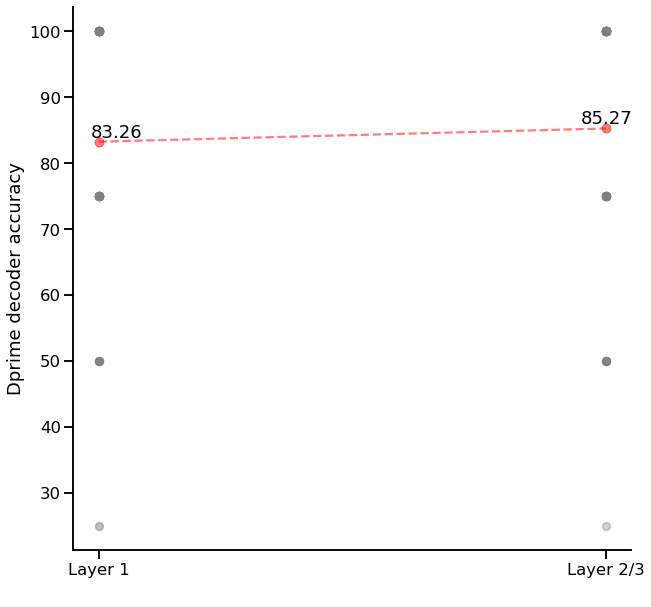

In [640]:
import seaborn as sns
sns.set_context("talk")
plt.figure(figsize=(10,10))
plt.scatter(np.zeros_like(DR_accuracy_l1_avg),DR_accuracy_l1_avg,c="grey",s=60, alpha = 0.2)
plt.scatter(np.ones_like(DR_accuracy_l2_avg),DR_accuracy_l2_avg,c="grey",s=60, alpha = 0.2)
point1 = [0, DR_accuracy_l1_avg.mean()]
point2 = [1, DR_accuracy_l2_avg.mean()]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values, 'ro', linestyle="--", alpha = 0.5)
plt.text(point1[0]-0.015, point1[1]+0.70, str(np.round(DR_accuracy_l1_avg.mean(),2)))
plt.text(point2[0]-0.050, point2[1]+0.70, str(np.round(DR_accuracy_l2_avg.mean(),2)))
plt.ylabel("Dprime decoder accuracy")
plt.xticks([0, 1],["Layer 1", "Layer 2/3"])
plt.xlabel(" ");
sns.despine()

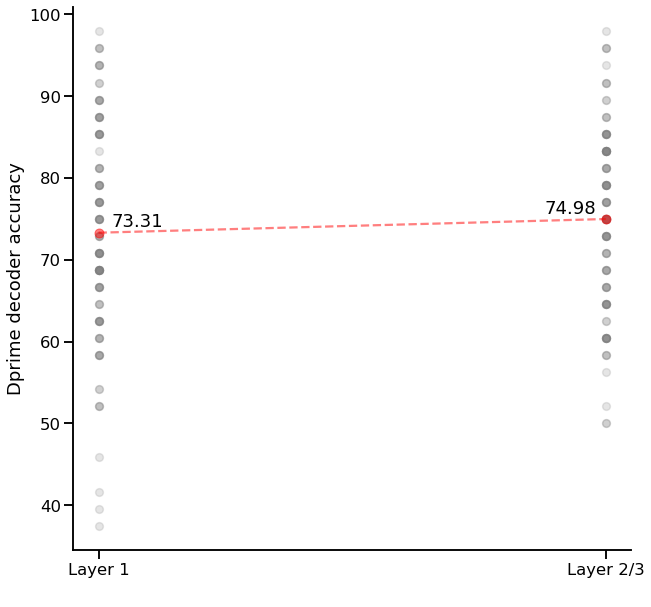

In [643]:
plt.figure(figsize=(10,10))
plt.scatter(np.zeros_like(DR_accuracy_l1_noavg),DR_accuracy_l1_noavg,c="grey",s=60, alpha = 0.2)
plt.scatter(np.ones_like(DR_accuracy_l2_noavg),DR_accuracy_l2_noavg,c="grey",s=60, alpha = 0.2)
point1 = [0, DR_accuracy_l1_noavg.mean()]
point2 = [1, DR_accuracy_l2_noavg.mean()]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values, 'ro', linestyle="--", alpha = 0.5)
plt.text(point1[0]+0.025, point1[1]+0.70, str(np.round(DR_accuracy_l1_noavg.mean(),2)))
plt.text(point2[0]-0.12, point2[1]+0.70, str(np.round(DR_accuracy_l2_noavg.mean(),2)))
plt.ylabel("Dprime decoder accuracy")
plt.xticks([0, 1],["Layer 1", "Layer 2/3"])
plt.xlabel(" ");
sns.despine()

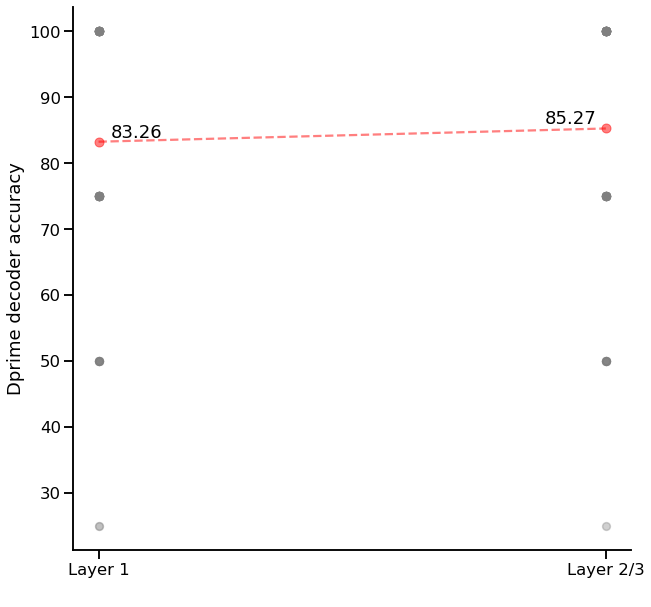

In [661]:
plt.figure(figsize=(10,10))
plt.scatter(np.zeros_like(DR_accuracy_l1_avg),DR_accuracy_l1_avg,c="grey",s=60, alpha = 0.2)
plt.scatter(np.ones_like(DR_accuracy_l2_avg),DR_accuracy_l2_avg,c="grey",s=60, alpha = 0.2)
point1 = [0, DR_accuracy_l1_avg.mean()]
point2 = [1, DR_accuracy_l2_avg.mean()]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values, 'ro', linestyle="--", alpha = 0.5)
plt.text(point1[0]+0.025, point1[1]+0.70, str(np.round(DR_accuracy_l1_avg.mean(),2)))
plt.text(point2[0]-0.12, point2[1]+0.70, str(np.round(DR_accuracy_l2_avg.mean(),2)))
plt.ylabel("Dprime decoder accuracy")
plt.xticks([0, 1],["Layer 1", "Layer 2/3"])
plt.xlabel(" ");
sns.despine()

NORMAL MOUSE

In [645]:
iexp       = 1
timeline   = utils.load_exp_info(exp_db[iexp])
spks, xpos, ypos, iplane, stat, ops = utils.load_neurons(exp_db[iexp], dual_plane=True, baseline=True)
neurons_atframes, subset_stim = utils.get_neurons_atframes(timeline,spks)
cats, stim_idx = utils.get_stim_class_and_samples_ix(subset_stim, n_categories=8, samples_per_cat=4)

(20,)
plane 0,  neurons: 1098
plane 1,  neurons: 4180
plane 2,  neurons: 5125
plane 3,  neurons: 4101
plane 4,  neurons: 2319
plane 5,  neurons: 2326
plane 6,  neurons: 5271
plane 7,  neurons: 4153
plane 8,  neurons: 4344
plane 9,  neurons: 2990
plane 10,  neurons: 684
plane 11,  neurons: 2519
plane 12,  neurons: 2965
plane 13,  neurons: 2655
plane 14,  neurons: 1535
plane 15,  neurons: 1882
plane 16,  neurons: 3598
plane 17,  neurons: 2869
plane 18,  neurons: 2918
plane 19,  neurons: 1649
total neurons 59181
8 categories, 32 exemplars, 98 repeats


In [646]:
TX_accuracy_l1_avg, pairs, _, _ = PairwiseDprimeDecoder(neurons_atframes, stim_idx, iplane, cats, n_categories = 8, n_samples = 4, layer = 1 , avg_reps = True)
TX_accuracy_l2_avg, _, _, _= PairwiseDprimeDecoder(neurons_atframes, stim_idx, iplane, cats, n_categories = 8, n_samples = 4, layer = 2 , avg_reps = True)
TX_accuracy_l1_noavg, _, _, _ = PairwiseDprimeDecoder(neurons_atframes, stim_idx, iplane, cats, n_categories = 8, n_samples = 4, layer = 1 , avg_reps = False)
TX_accuracy_l2_noavg, _, _, _ = PairwiseDprimeDecoder(neurons_atframes, stim_idx, iplane, cats, n_categories = 8, n_samples = 4, layer = 2 , avg_reps = False)

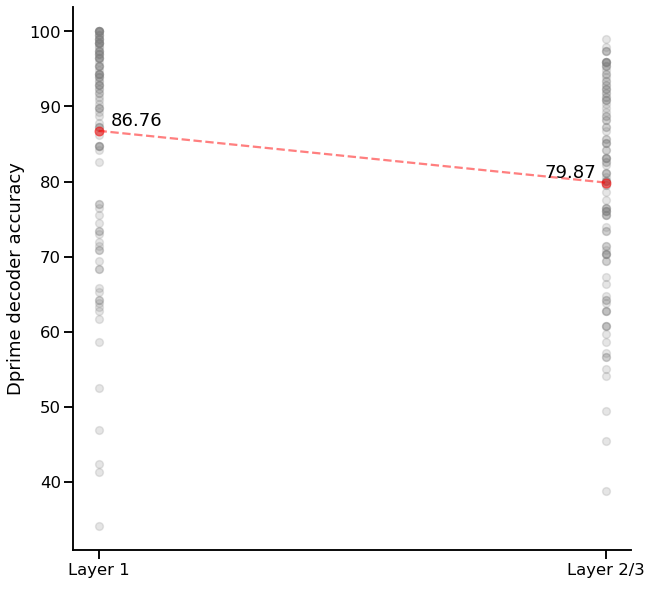

In [647]:
plt.figure(figsize=(10,10))
plt.scatter(np.zeros_like(TX_accuracy_l1_noavg),TX_accuracy_l1_noavg,c="grey",s=60, alpha = 0.2)
plt.scatter(np.ones_like(TX_accuracy_l2_noavg),TX_accuracy_l2_noavg,c="grey",s=60, alpha = 0.2)
point1 = [0, TX_accuracy_l1_noavg.mean()]
point2 = [1, TX_accuracy_l2_noavg.mean()]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values, 'ro', linestyle="--", alpha = 0.5)
plt.text(point1[0]+0.025, point1[1]+0.70, str(np.round(TX_accuracy_l1_noavg.mean(),2)))
plt.text(point2[0]-0.12, point2[1]+0.70, str(np.round(TX_accuracy_l2_noavg.mean(),2)))
plt.ylabel("Dprime decoder accuracy")
plt.xticks([0, 1],["Layer 1", "Layer 2/3"])
plt.xlabel(" ");
sns.despine()

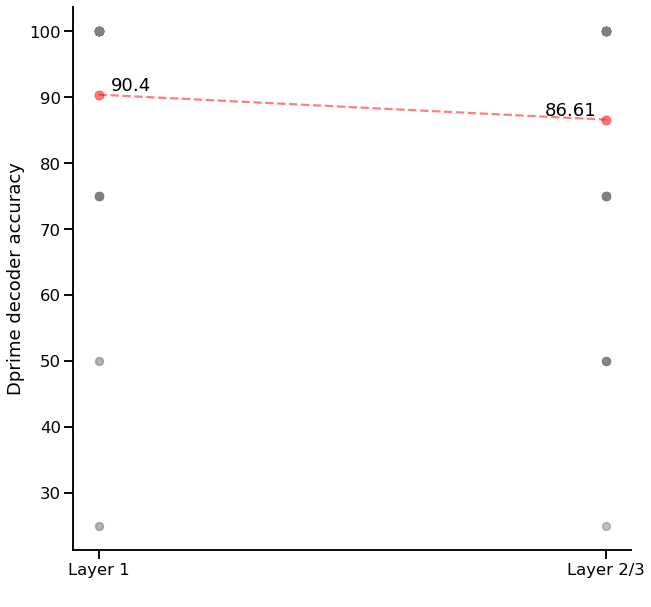

In [660]:
plt.figure(figsize=(10,10))
plt.scatter(np.zeros_like(TX_accuracy_l1_avg),TX_accuracy_l1_avg,c="grey",s=60, alpha = 0.2)
plt.scatter(np.ones_like(TX_accuracy_l2_avg),TX_accuracy_l2_avg,c="grey",s=60, alpha = 0.2)
point1 = [0, TX_accuracy_l1_avg.mean()]
point2 = [1, TX_accuracy_l2_avg.mean()]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values, 'ro', linestyle="--", alpha = 0.5)
plt.text(point1[0]+0.025, point1[1]+0.70, str(np.round(TX_accuracy_l1_avg.mean(),2)))
plt.text(point2[0]-0.12, point2[1]+0.70, str(np.round(TX_accuracy_l2_avg.mean(),2)))
plt.ylabel("Dprime decoder accuracy")
plt.xticks([0, 1],["Layer 1", "Layer 2/3"])
plt.xlabel(" ");
sns.despine()

# margin inspection 

In [709]:
_, pairs, spops, cat_dict = PairwiseDprimeDecoder(neurons_atframes, stim_idx, iplane, cats, n_categories = 8, n_samples = 4, layer = 1 , avg_reps = True)

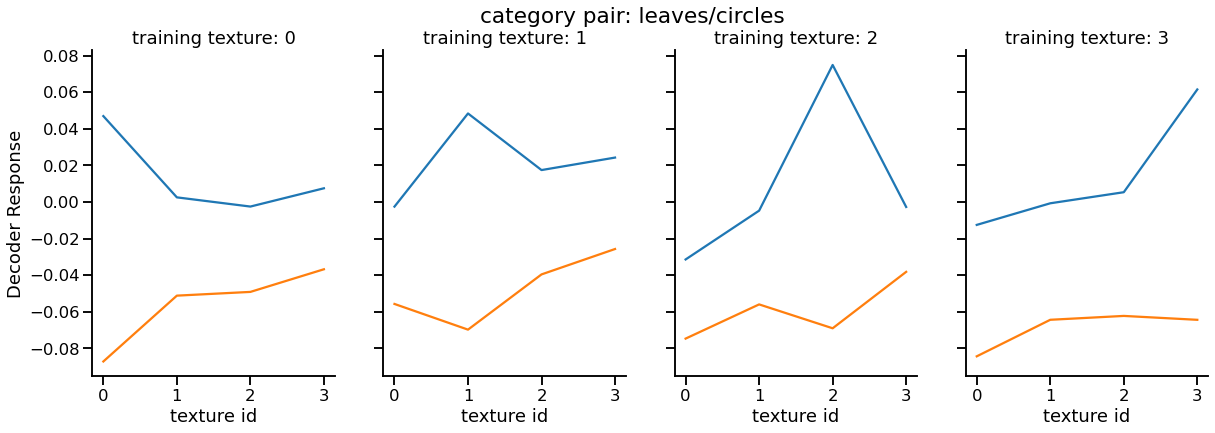

In [735]:
selected_pair = 0
training_textures = np.arange(4)
fig, ax = plt.subplots(1, len(training_textures), sharex='all', sharey='all', figsize=(20,6))
fig.suptitle(f"category pair: {cat_dict[str(pairs[selected_pair][0])]}/{cat_dict[str(pairs[selected_pair][1])]}")
ax[0].set_ylabel("Decoder Response")
for texture in training_textures:
    ax[texture].set_title(f"training texture: {texture}")
    ax[texture].plot(spops[selected_pair,texture][0])
    ax[texture].plot(spops[selected_pair,texture][1])
    ax[texture].set_xlabel("texture id")
    sns.despine()

In [776]:
def get_generalization_margings(spops, n_pairs = 28, n_textures = 4):
    generalization_margings = np.empty((28,4), dtype=object)
    for pair in range(n_pairs):
        for train_tex in range(n_textures):
            margings = spops[pair,train_tex][0] - spops[pair,train_tex][1]
            train_marging = margings[train_tex]
            margin_ratio = margings/train_marging
            generalization_margings[pair,train_tex] = margin_ratio
    return generalization_margings

In [788]:
def get_margin_per_category(margins,category_pair,avg=True):
    margins_atcatpair = np.concatenate(margins[category_pair,:],axis=0).reshape(4,4)
    if avg:
        margins_atcatpair[margins_atcatpair==1] = np.nan
        margins_atcatpair = np.nanmean(margins_atcatpair,axis=1)
    return margins_atcatpair

In [797]:
def categorypairs_parser(cat_dict,pairs):
    category_pairs = []
    for pair in pairs:
        category_pairs.append(f"{cat_dict[str(pair[0])]}/{cat_dict[str(pair[1])]}")
    return category_pairs

In [825]:
cat_pairs = categorypairs_parser(cat_dict,pairs)
cat_pairs

['leaves/circles',
 'leaves/dryland',
 'leaves/rocks',
 'leaves/tiles',
 'leaves/squares',
 'leaves/round leaves',
 'leaves/paved',
 'circles/dryland',
 'circles/rocks',
 'circles/tiles',
 'circles/squares',
 'circles/round leaves',
 'circles/paved',
 'dryland/rocks',
 'dryland/tiles',
 'dryland/squares',
 'dryland/round leaves',
 'dryland/paved',
 'rocks/tiles',
 'rocks/squares',
 'rocks/round leaves',
 'rocks/paved',
 'tiles/squares',
 'tiles/round leaves',
 'tiles/paved',
 'squares/round leaves',
 'squares/paved',
 'round leaves/paved']

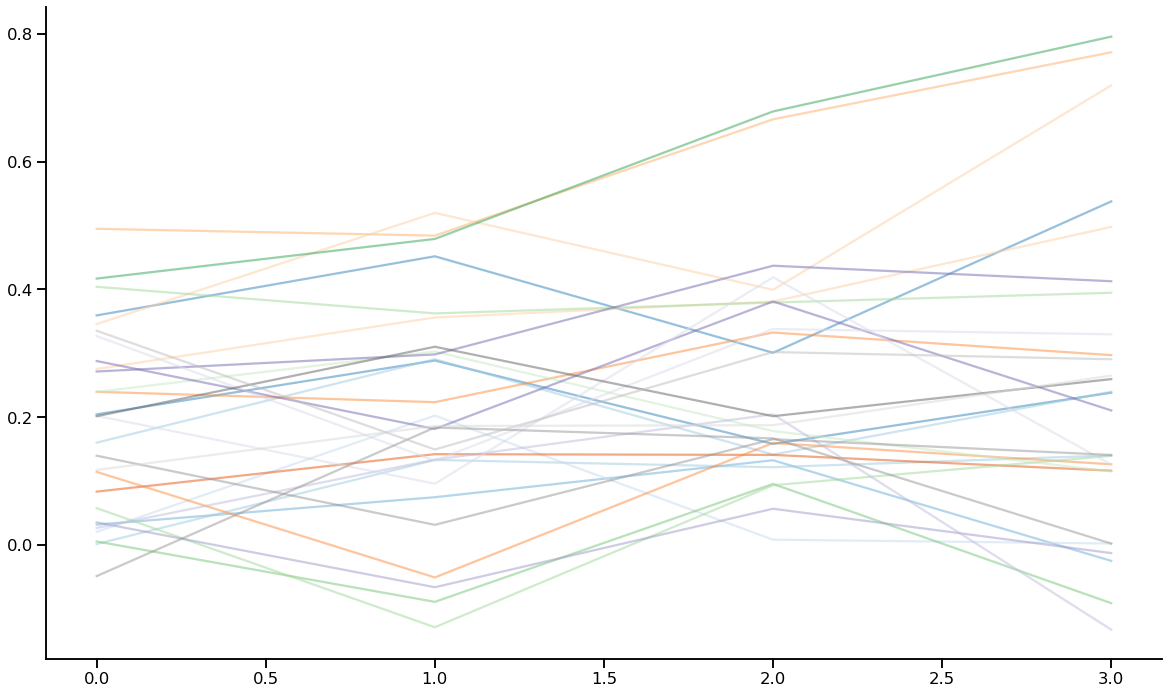

In [848]:
import matplotlib as mpl
cmap = mpl.cm.tab20c
n_pairs = 28
plt.figure(figsize=(20,12))
cat_pairs = categorypairs_parser(cat_dict,pairs)
for pair in range(n_pairs):
    mean_margin = get_margin_per_category(a,pair,avg=True)
    plt.plot(mean_margin,alpha=0.5, color=cmap(pair/n_pairs))
    #plt.scatter(1, mean_margin.mean(),alpha=0.5)
    #plt.text(3+0.1, mean_margin[3], cat_pairs[pair])
sns.despine()

In [849]:
_, pairs, spops_L1, cat_dict = PairwiseDprimeDecoder(neurons_atframes, stim_idx, iplane, cats, n_categories = 8, n_samples = 4, layer = 1 , avg_reps = True)
_, _, spops_L2, _ = PairwiseDprimeDecoder(neurons_atframes, stim_idx, iplane, cats, n_categories = 8, n_samples = 4, layer = 2 , avg_reps = True)
gen_marg_L1 = get_generalization_margings(spops_L1, n_pairs = 28, n_textures = 4)
gen_marg_L2 = get_generalization_margings(spops_L2, n_pairs = 28, n_textures = 4)

In [853]:
n_pairs = 28
mean_margin_L1 = []
mean_margin_L2 = []
for pair in range(n_pairs):
    mean_margin_L1.append(get_margin_per_category(gen_marg_L1,pair,avg=True))
    mean_margin_L2.append(get_margin_per_category(gen_marg_L2,pair,avg=True))
mean_margin_L1 = np.array(mean_margin_L1)
mean_margin_L2 = np.array(mean_margin_L2)

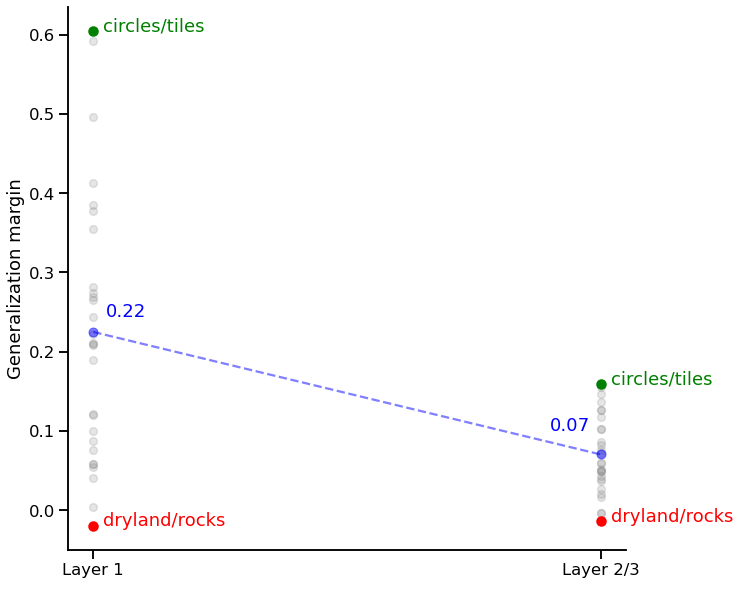

In [885]:
plt.figure(figsize=(10,10))
maxpair_L1 = mean_margin_L1.mean(1).argmax()
minpair_L1 = mean_margin_L1.mean(1).argmin()
maxpair_L2 = mean_margin_L2.mean(1).argmax()
minpair_L2 = mean_margin_L2.mean(1).argmin()
plt.scatter(np.zeros_like(mean_margin_L1.mean(1)),mean_margin_L1.mean(1),c="grey",s=60, alpha = 0.2)
plt.scatter(np.ones_like(mean_margin_L2.mean(1)),mean_margin_L2.mean(1),c="grey",s=60, alpha = 0.2)
point1 = [0, mean_margin_L1.mean()]
point2 = [1, mean_margin_L2.mean()]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values, 'bo', linestyle="--", alpha = 0.5)
plt.text(point1[0]+0.025, point1[1]+0.02, str(np.round(mean_margin_L1.mean(),2)), color = "b")
plt.text(point2[0]-0.10, point2[1]+0.03, str(np.round(mean_margin_L2.mean(),2)), color = "b")
plt.scatter(0, mean_margin_L1.mean(1).max(),color="g")
plt.scatter(0, mean_margin_L1.mean(1).min(),color="r")
plt.text(0+.02, mean_margin_L1.mean(1).max(), cat_pairs[maxpair_L1], color = "g")
plt.text(0+.02, mean_margin_L1.mean(1).min(), cat_pairs[minpair_L1], color = "r")
plt.scatter(1, mean_margin_L2.mean(1).max(),color="g")
plt.scatter(1, mean_margin_L2.mean(1).min(),color="r")
plt.text(1+.02, mean_margin_L2.mean(1).max(), cat_pairs[maxpair_L2], color = "g")
plt.text(1+.02, mean_margin_L2.mean(1).min(), cat_pairs[minpair_L2], color = "r")
plt.ylabel("Generalization margin")
plt.xticks([0, 1],["Layer 1", "Layer 2/3"])
plt.xlabel(" ");
sns.despine()

In [ ]:
iexp       = 0
timeline   = utils.load_exp_info(exp_db[iexp])
spks, xpos, ypos, iplane, stat, ops = utils.load_neurons(exp_db[iexp], dual_plane=True, baseline=True)
neurons_atframes, subset_stim = utils.get_neurons_atframes(timeline,spks)
cats, stim_idx = utils.get_stim_class_and_samples_ix(subset_stim, n_categories=8, samples_per_cat=4)

In [ ]:
_, pairs, spops_L1, cat_dict = PairwiseDprimeDecoder(neurons_atframes, stim_idx, iplane, cats, n_categories = 8, n_samples = 4, layer = 1 , avg_reps = True)
_, _, spops_L2, _ = PairwiseDprimeDecoder(neurons_atframes, stim_idx, iplane, cats, n_categories = 8, n_samples = 4, layer = 2 , avg_reps = True)
gen_marg_L1 = get_generalization_margings(spops_L1, n_pairs = 28, n_textures = 4)
gen_marg_L2 = get_generalization_margings(spops_L2, n_pairs = 28, n_textures = 4)

In [ ]:
n_pairs = 28
mean_margin_L1 = []
mean_margin_L2 = []
for pair in range(n_pairs):
    mean_margin_L1.append(get_margin_per_category(gen_marg_L1,pair,avg=True))
    mean_margin_L2.append(get_margin_per_category(gen_marg_L2,pair,avg=True))
mean_margin_L1 = np.array(mean_margin_L1)
mean_margin_L2 = np.array(mean_margin_L2)

In [ ]:
plt.figure(figsize=(10,10))
maxpair_L1 = mean_margin_L1.mean(1).argmax()
minpair_L1 = mean_margin_L1.mean(1).argmin()
maxpair_L2 = mean_margin_L2.mean(1).argmax()
minpair_L2 = mean_margin_L2.mean(1).argmin()
plt.scatter(np.zeros_like(mean_margin_L1.mean(1)),mean_margin_L1.mean(1),c="grey",s=60, alpha = 0.2)
plt.scatter(np.ones_like(mean_margin_L2.mean(1)),mean_margin_L2.mean(1),c="grey",s=60, alpha = 0.2)
point1 = [0, mean_margin_L1.mean()]
point2 = [1, mean_margin_L2.mean()]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values, 'bo', linestyle="--", alpha = 0.5)
plt.text(point1[0]+0.025, point1[1]+0.02, str(np.round(mean_margin_L1.mean(),2)), color = "b")
plt.text(point2[0]-0.10, point2[1]+0.03, str(np.round(mean_margin_L2.mean(),2)), color = "b")
plt.scatter(0, mean_margin_L1.mean(1).max(),color="g")
plt.scatter(0, mean_margin_L1.mean(1).min(),color="r")
plt.text(0+.02, mean_margin_L1.mean(1).max(), cat_pairs[maxpair_L1], color = "g")
plt.text(0+.02, mean_margin_L1.mean(1).min(), cat_pairs[minpair_L1], color = "r")
plt.scatter(1, mean_margin_L2.mean(1).max(),color="g")
plt.scatter(1, mean_margin_L2.mean(1).min(),color="r")
plt.text(1+.02, mean_margin_L2.mean(1).max(), cat_pairs[maxpair_L2], color = "g")
plt.text(1+.02, mean_margin_L2.mean(1).min(), cat_pairs[minpair_L2], color = "r")
plt.ylabel("Generalization margin")
plt.xticks([0, 1],["Layer 1", "Layer 2/3"])
plt.xlabel(" ");
sns.despine()